In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# path = '/content/gdrive/MyDrive/Applied ML/'
path = './ml-100k/'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# from google.colab import files

# warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format='retina'

np.random.seed(3333)

from copy import deepcopy
import multiprocessing
from functools import partial
import time

# Class definition

In [48]:
class Mle:
  def __init__(self, data_path:str, sep:str='\t', remove_head:bool=False) -> None:
    self.data_path = data_path
    self.sep = sep
    self.remove_head = remove_head

    self.users_id = {};                 self.items_id = {}

    self.users_rating = [];             self.items_rating = []
    self.users_rating_train = [];       self.items_rating_train = []
    self.users_rating_test = [];        self.items_rating_test = []

    self.user_total_rating = [];        self.item_total_rating = []
    self.user_total_rating_train = [];  self.item_total_rating_train = []
    self.user_total_rating_test = [];   self.item_total_rating_test = []

    self.user_cum_rating = [];          self.item_cum_rating = []
    self.user_cum_rating_train = [];    self.item_cum_rating_train = []
    self.user_cum_rating_test = [];     self.item_cum_rating_test = []

    self.users_freq_rating = [];        self.items_freq_rating = []
    self.users_uniq_rating_nbr = [];    self.items_uniq_rating_nbr = []

    self.number_of_users = self.number_of_items = 0

    self.mle_train = None; self.rmse_train = None
    self.rmse_test = None
    # self.mle_test = None; self.rmse_test = None

    self.dim = 2

    self.get_data()
    self.split_data()
    self.get_freq()


  def get_data(self) -> None:
    with open(self.data_path, 'r') as data_file:
      data = data_file.readlines()
      uid = {};       mid = {}
      urat = [];      mrat = []
      ucount = [];    mcount = []

      a = b = 0
      i = j = 0
      rm = False
      for d in data:
        if self.remove_head and not(rm):
          rm = not(rm)
          pass
        u = d.split()
        if u[0] not in uid:
          uid[u[0]] = a
          ucount += [1]
          i = sum(ucount)
          a += 1
        else:
          ucount[uid[u[0]]] += 1
          i = sum(ucount[0:uid[u[0]]])

        if u[1] not in mid:
          mid[u[1]] = b
          mcount += [1]
          j = sum(mcount)
          b += 1
        else:
          mcount[mid[u[1]]] += 1
          j = sum(mcount[0:mid[u[1]]])
        urat.insert(i, (mid[u[1]], int(u[2])))
        mrat.insert(j, (uid[u[0]], int(u[2])))

      nbr_user, nbr_movie = len(ucount), len(mcount)

      ucumcount, mcumcount = ucount.copy(), mcount.copy()
      for i in range(1,max(nbr_user, nbr_movie)):
        if i < nbr_user:
          ucumcount[i] += ucumcount[i-1]
        if i < nbr_movie:
          mcumcount[i] += mcumcount[i-1]

      self.users_id = uid;                self.items_id = mid
      self.users_rating = urat;           self.items_rating = mrat
      self.number_of_users = nbr_user;    self.number_of_items = nbr_movie
      self.user_total_rating = np.array(ucount);    self.item_total_rating = np.array(mcount)
      self.user_cum_rating = np.array(ucumcount);   self.item_cum_rating = np.array(mcumcount)
    data_file.close()


  def split_data(self, ratio=0.1):
    nbr_user = self.number_of_users; nbr_movie = self.number_of_items
    mrtr = []; irtr = {}; items_rating_train = []
    mrts = []; irts = {}; items_rating_test  = []

    for m in range(nbr_user):
      urat = self.get_user_movies_and_ratings(m, self.users_rating, self.user_cum_rating)
      ui = len(urat)
      uj = int(np.round(ui*ratio))
      uk = np.random.choice(ui, uj, replace=False)
      for i, (n,r) in enumerate(urat):
        if i in uk:
          mrts += [(n, r)]
          if n not in irts:
            irts[n] = [(m, r)]
          else:
            irts[n] += [(m, r)]
        else:
          mrtr += [(n, r)]
          if n not in irtr:
            irtr[n] = [(m, r)]
          else:
            irtr[n] += [(m, r)]
      self.user_total_rating_train += [ui-uj];    self.user_total_rating_test  += [uj]

    for n in range(nbr_movie):
      if n in irtr:
        items_rating_train += irtr[n];    self.item_total_rating_train += [len(irtr[n])]
      else:
        self.item_total_rating_train += [0]

      if n in irts:
        items_rating_test  += irts[n];    self.item_total_rating_test += [len(irts[n])]
      else:
        self.item_total_rating_test += [0]

    self.users_rating_train = mrtr;   self.items_rating_train = items_rating_train
    self.users_rating_test  = mrts;   self.items_rating_test = items_rating_test
    self.user_cum_rating_train = np.cumsum(self.user_total_rating_train)
    self.item_cum_rating_train = np.cumsum(self.item_total_rating_train)
    self.user_cum_rating_test = np.cumsum(self.user_total_rating_test)
    self.item_cum_rating_test = np.cumsum(self.item_total_rating_test)


  def get_freq(self) -> None:
    u, m = np.array(self.user_total_rating), np.array(self.item_total_rating)
    ufreq = []; mfreq = []
    uuniq = []; muniq = []
    while True:
      if len(u) == 0 & len(m) == 0:
        break
      if len(u) > 0:
        ufreq += [len(u[u==u[0]])]
        uuniq += [u[0]]
        u = u[u!=u[0]]
      if len(m) > 0:
        mfreq += [len(m[m==m[0]])]
        muniq += [m[0]]
        m = m[m!=m[0]]

    self.users_freq_rating = ufreq;  self.items_freq_rating = mfreq
    self.users_uniq_rating_nbr = uuniq;  self.items_uniq_rating_nbr = muniq


  def plot_freq(self, fgsize=[6,6], ftsize=11, alpha=0.7,
                title = 'Power low', xlabel = 'count', ylabel = 'frequency',
                ulabel = 'per user', mlabel = 'per movie',
                ucolor = '#0E88FF', mcolor = '#FF0000'):
    # Initialisation
    ux = self.users_uniq_rating_nbr
    mx = self.items_uniq_rating_nbr
    uy = self.users_freq_rating
    my = self.items_freq_rating

    fig, ax = plt.subplots(figsize=fgsize)

    # Annotate y-axis
    ax.set_xscale("log", base=10)
    ax.set_yscale("log", base=10)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Plot
    ax.scatter(ux, uy, alpha=alpha, color=ucolor, label=ulabel)
    ax.scatter(mx, my, alpha=alpha, color=mcolor, label=mlabel)

    # Legend
    ax.legend(fontsize=ftsize)
    ax.set_title(title, pad=10)
    self.save_plot(plt, 'power-low')
    plt.draw()
    plt.show()

  def mle_loss(self, lambd:float=0.01, gamma:float=0.01, tau:float=0.01,
               E:float=5, mu:float=0, dim:int=None, nbr_iter=50, update:bool=True) -> None:

    # Initialisation
    nbr_user = self.number_of_users; nbr_movie = self.number_of_items
    if dim is None:
      dim = self.dim
    else:
      self.dim = dim
    std = np.sqrt(E / np.sqrt(dim))

    upred = np.random.normal(mu, std, size=(nbr_user, dim))
    mpred = np.random.normal(mu, std, size=(nbr_movie, dim))

    ubiases = np.zeros(nbr_user)
    mbiases = np.zeros(nbr_movie)
    mle_train = np.zeros(nbr_iter); rmse_train = np.zeros(nbr_iter)
    rmse_test = np.zeros(nbr_iter)
    # mle_test = np.zeros(nbr_iter); rmse_test = np.zeros(nbr_iter)

    # Loss calculation
    for i in range(nbr_iter):
      # Initialisation
      usumb2 = msumb2 = 0 # sum of biases squared
      usumpred2 = msumpred2 = 0 # sum of prediction squared

      # Biases
      ## User
      for m in range(nbr_user):
        b = 0
        ratings = self.get_user_movies_and_ratings(m, self.users_rating_train, self.user_cum_rating_train)
        for n, r in ratings:
          b = b + lambd * (r - (np.dot(upred[m], mpred[n]) + mbiases[n]))
        b = b / (lambd * len(ratings) + gamma)
        ubiases[m] = b
        usumb2 = usumb2 + b**2
        usumpred2 = usumpred2 + np.dot(upred[m], upred[m])
      ## Item
      for n in range(nbr_movie):
        b = 0
        ratings = self.get_movie_users_and_ratings(n, self.items_rating_train, self.item_cum_rating_train)
        for m, r in ratings:
          b += lambd * (r - (np.dot(upred[m], mpred[n]) + ubiases[m]))
        b = b / (lambd * len(ratings) + gamma)
        mbiases[n] = b
        msumb2 = msumb2 + b**2
        msumpred2 = msumpred2 + np.dot(mpred[n], mpred[n])

      # Update
      if update:
      ## User
        for m in range(nbr_user):
          ratings = self.get_user_movies_and_ratings(m, self.users_rating_train, self.user_cum_rating_train)
          A = np.zeros((dim,dim));   x = np.zeros(dim)
          for n, r in ratings:
            A += lambd * np.outer(mpred[n],mpred[n])
            x += lambd * mpred[n] * (r - (ubiases[m] + mbiases[n]))
          A += tau * np.eye(dim)
          L = np.linalg.cholesky(A)
          upred[m] = np.linalg.inv(np.transpose(L)) @ np.linalg.inv(L) @ x
      ## Item
        for n in range(nbr_movie):
          ratings = self.get_movie_users_and_ratings(n, self.items_rating_train, self.item_cum_rating_train)
          A = np.zeros((dim,dim));   x = np.zeros(dim)
          for m, r in ratings:
            A += lambd * np.outer(upred[m], upred[m])
            x += lambd * upred[m] * (r - (ubiases[m] + mbiases[n]))
          A += tau * np.eye(dim)
          L = np.linalg.cholesky(A)
          mpred[n] = np.linalg.inv(np.transpose(L)) @ np.linalg.inv(L) @ x

      # Loss
      ## Train data
      mle1 = rmse1 = 0
      for m in range(nbr_user):
        ratings = self.get_user_movies_and_ratings(m, self.users_rating_train, self.user_cum_rating_train)
        for n, r in ratings:
          mle1 = mle1 + (r - (np.dot(upred[m], mpred[n]) + ubiases[m] + mbiases[n]))**2
      mle_train[i] = - (lambd*mle1 + gamma*(usumb2+msumb2) + update * tau*(usumpred2+msumpred2))/2
      rmse_train[i] = np.sqrt(mle1 / self.user_cum_rating_train[-1])

      ## Test data
      mle1 = rmse1 = 0
      for m in range(nbr_user):
        ratings = self.get_user_movies_and_ratings(m, self.users_rating_test, self.user_cum_rating_test)
        for n, r in ratings:
          mle1 = mle1 + (r - (np.dot(upred[m], mpred[n]) + ubiases[m] + mbiases[n]))**2
      # mle_test[i] = - (lambd*mle1 + gamma*(usumb2+msumb2) + update * tau*(usumpred2+msumpred2))/2
      rmse_test[i] = np.sqrt(mle1 / self.user_cum_rating_test[-1])

    self.mle_train = mle_train;   self.rmse_train = rmse_train
    self.rmse_test = rmse_test
    # self.mle_test = mle_test;     self.rmse_test = rmse_test


  def plot_loss(self, error='mle', save=False, fgname='mle', fgsize=[6,6], ftsize=11, alpha=1,
                title = 'Lost function', xlabel = 'Iteration', ylabel = 'mle value',
                lcolor = '#0E88FF', ecolor = '#FF0000') -> None:
    # Initialisation
    if self.mle_train is None:
      self.mle_loss()
    y_train = self.mle_train if error == 'mle' else self.rmse_train
    y_test  = []  if error == 'mle' else self.rmse_test
    N = len(y_train)
    x = np.array(range(1,N+1))

    fig, ax = plt.subplots(figsize=fgsize)

    # Annotate y-axis
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Plot
    ax.plot(x, y_train, alpha=alpha, color=lcolor, marker="+", label='Training set')
    if error == 'rmse':
      ax.plot(x, y_test, alpha=alpha, color=ecolor, marker="*", label='Testing set')

    # Legend
    ax.legend(fontsize=ftsize)
    ax.set_title(f"{title} for dim = {self.dim}", pad=10)
    self.save_plot(plt, f'plots/{fgname}-dim{self.dim}-iter{N}', save=save)
    # plt.draw()
    # plt.show()

    return fig


  def plot_3d(self):
    # Make data.
    X = np.arange(-5, 5, 0.25)
    Y = np.arange(-5, 5, 0.25)
    X, Y = np.meshgrid(X, Y)
    R = np.sqrt(X**2 + Y**2)
    Z = np.sin(R)


  def get_user_movies_and_ratings(self, user_index, data=None, cum=None):
    if data is None:
      data = self.users_rating
      cum = self.user_cum_rating
    a = 0 if user_index == 0 else cum[user_index-1]
    b = cum[user_index]
    return data[a:b]

  def get_movie_users_and_ratings(self, movie_index, data=None, cum=None):
    if data is None:
      data = self.items_rating
      cum  = self.item_cum_rating
    a = 0 if movie_index == 0 else cum[movie_index-1]
    b = cum[movie_index]
    return data[a:b]

  def save_plot(self, fig_plt, name, ext='.pdf', save=True):
    if save:
      filenane = f"{name}{ext}"
      fig_plt.savefig(filenane)
    else:
      fig_plt.show()


Test

In [24]:
test = Mle(path + 'u.data')

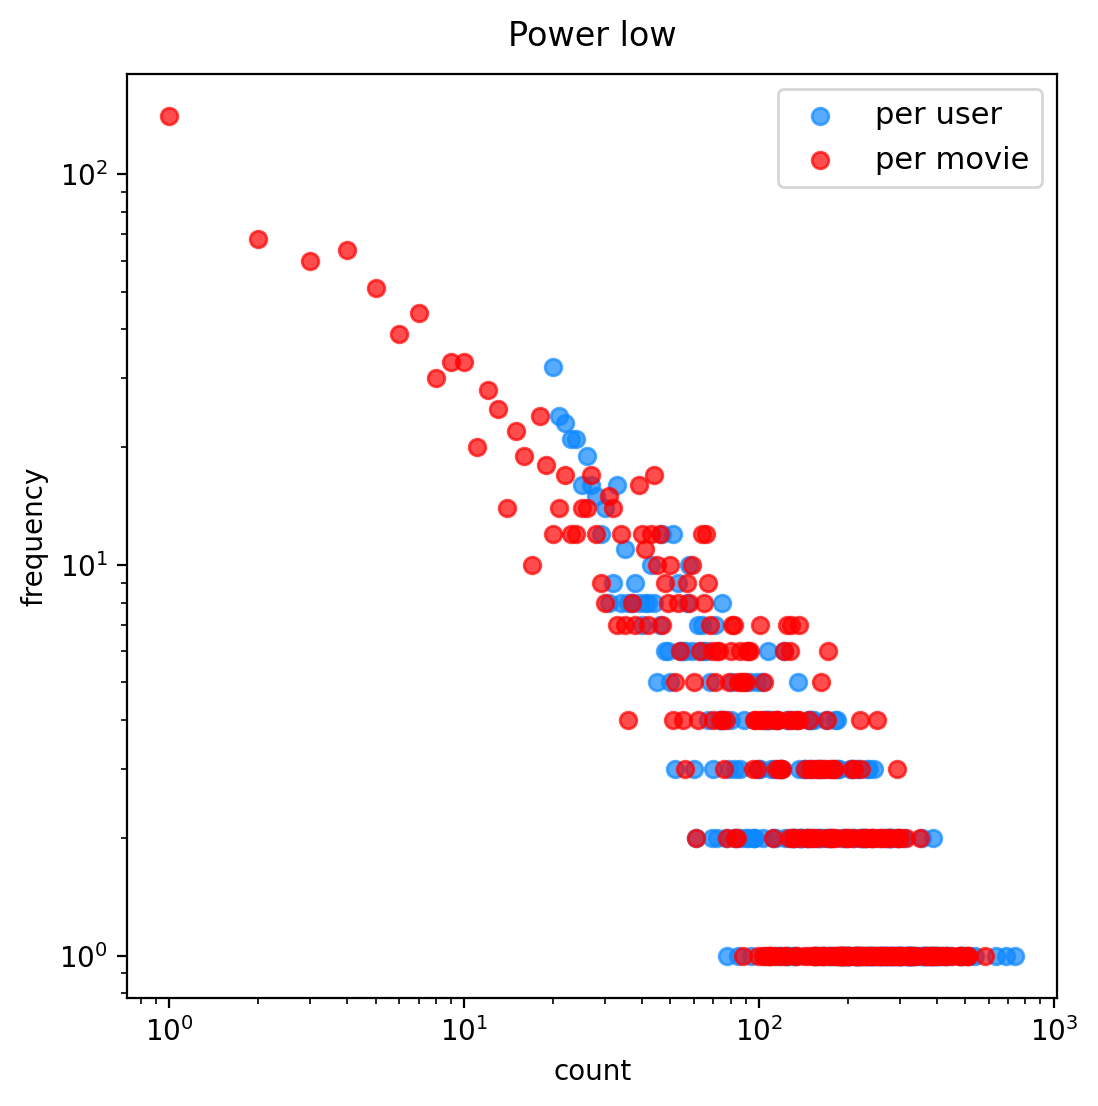

In [25]:
test.plot_freq()

In [26]:
test.mle_loss(update=1, nbr_iter=10, dim=2)

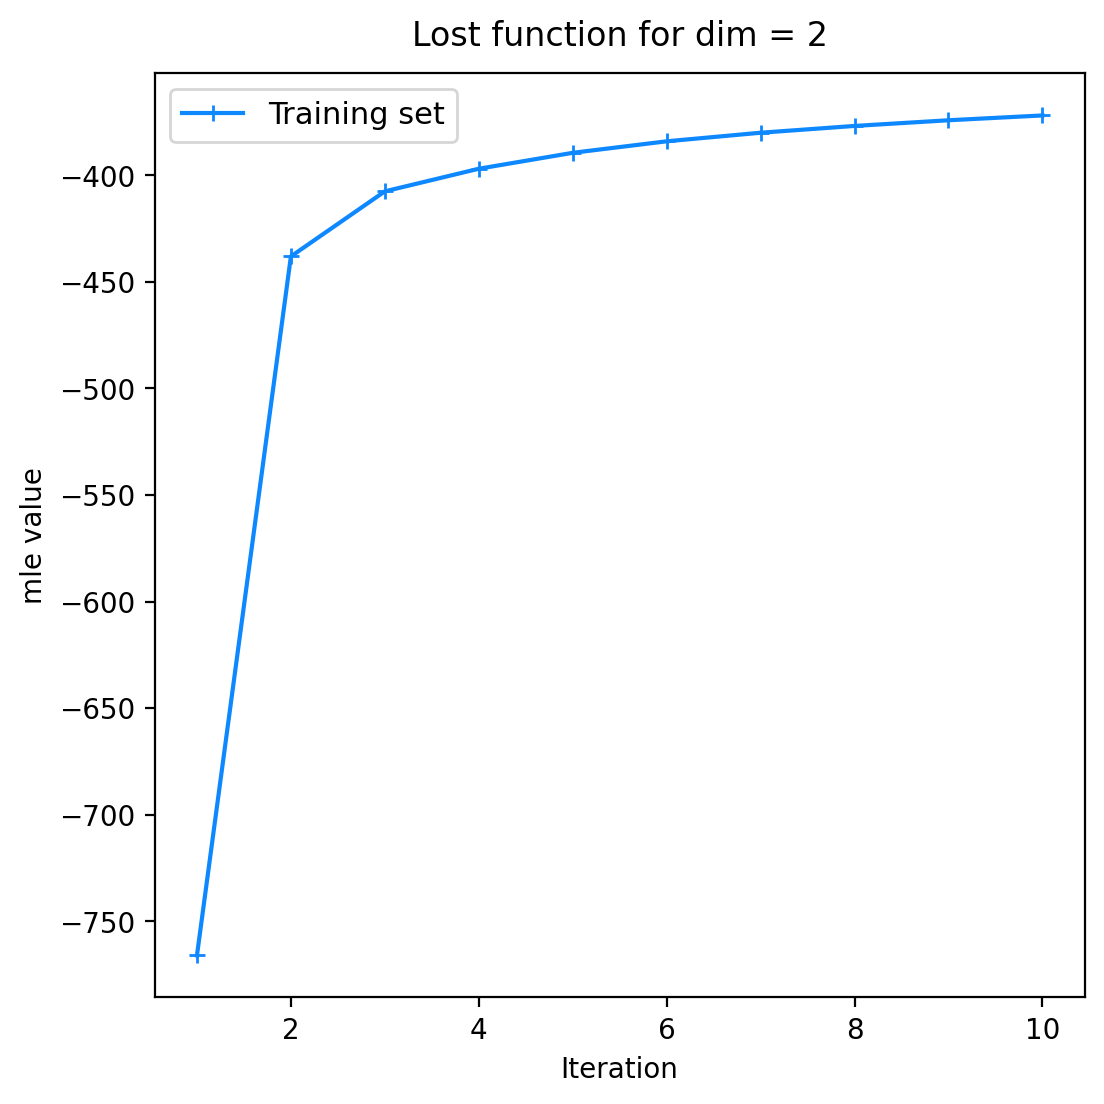

In [27]:
test.plot_loss()

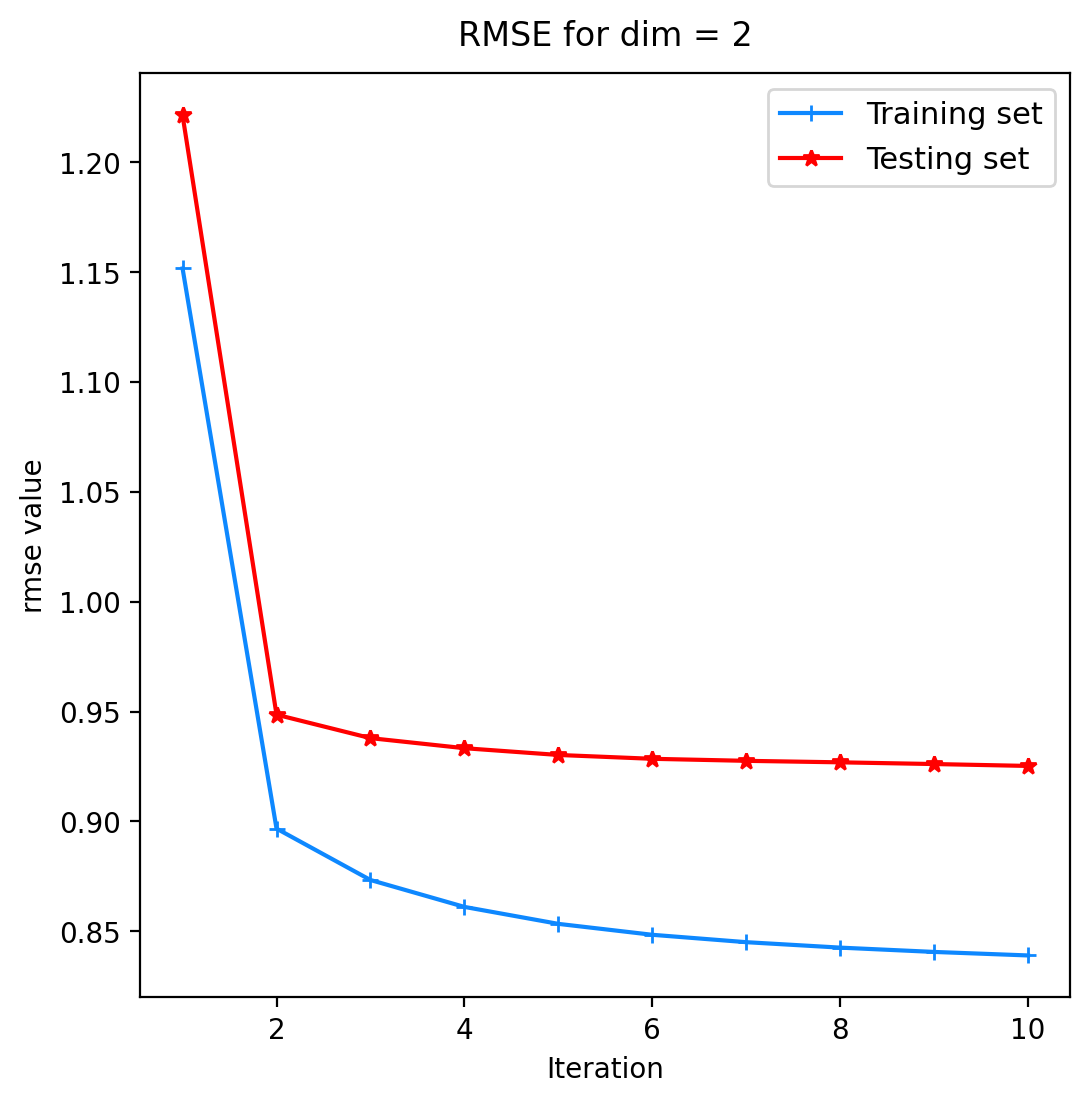

In [28]:
test.plot_loss(error='rmse', fgname='rmse', title='RMSE', ylabel='rmse value')

In [49]:

def multi_process(k, mle=None, N=30):
  # mle_copy = deepcopy(mle)
  mle_copy = mle
  mle_copy.mle_loss(update=1, nbr_iter=N, dim=k)
  mle_copy.plot_loss(save=True)
  mle_copy.plot_loss(error='rmse', save=True, fgname='rmse', title='RMSE', ylabel='rmse value')
  # print(f'N = {N}, k = {k} done')
  plt.show()

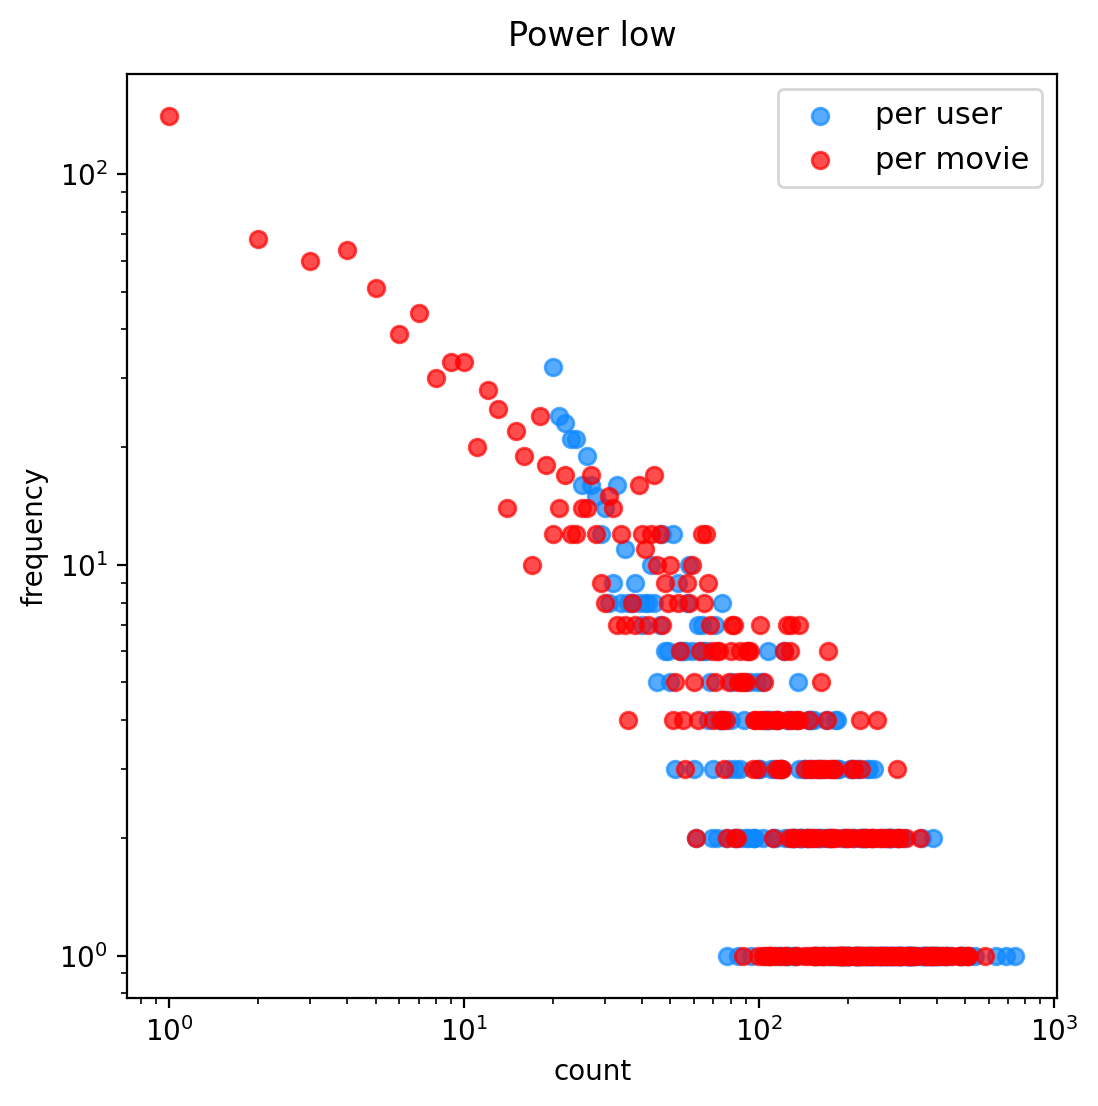

In [50]:
# plt.ion()
mle = Mle(path + 'u.data')
mle.plot_freq()

# mle.mle_loss(update=1, nbr_iter=10, dim=2)
# mle.plot_loss()
# mle.plot_loss(error='rmse', fgname='rmse', title='RMSE', ylabel='rmse value')

In [51]:
# multiprocessing
# plt.ion()
st = time.time()
# results = None
dims = [5, 2]
# dims = [2, 5, 10, 20, 50, 100]
n = 3
with multiprocessing.Pool(processes=10) as pool:
  pool.map(partial(multi_process, mle=mle, N=20), dims)
pool.close()
en = time.time()
print("time taken = ", en-st, "\n")

# plt.ioff()
# plt.show()

time taken =  20.458707094192505 



In [55]:
import os
from matplotlib import image as mpimg
from PIL import Image
from wand.image import Image as WImage


# assign directory
directory = 'plots'
 
# iterate over files in
# that directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        # image = mpimg.imread(f)
        # plt.imshow(image)
        # img = Image.open(f)
        # img.show()
        img = WImage(filename=f)
        img

ModuleNotFoundError: No module named 'wand'